In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Stripe Dataset

In [ ]:
import os
import random
from pathlib import Path

import numpy as np
from PIL import Image, UnidentifiedImageError

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    ControlNetModel,
    DDPMScheduler,
)
from diffusers.optimization import get_cosine_schedule_with_warmup
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator, notebook_launcher
from tqdm.auto import tqdm

import matplotlib.pyplot as plt


### New masking and resizing strategis have been implemented on data generation.


        1. Resize so min(H, W) >= check_size while preserving aspect ratio
        2. Random crop to (image_size, image_size)
        3. Generate striped version + stripe_control on the training. Removed pre-stored image logic.


In [ ]:
def make_sparse_row_mask(
    H,
    W,
    skip=None,
    skip_options=None,
    skip_probs=None,
    target_missing_ratio=None,
    device="cpu",
    dtype=torch.float32,
):

    # 1) Decide skip value
    if target_missing_ratio is not None:
        # missing_ratio = 1 - keep_ratio
        # keep_ratio = 1 / skip
        keep_ratio = max(1.0 - float(target_missing_ratio), 1e-6)
        skip = max(int(round(1.0 / keep_ratio)), 1)

    elif skip_options is not None:
        if skip_probs is None:
            skip = random.choice(skip_options)
        else:
            s = float(sum(skip_probs))
            if s <= 0:
                raise ValueError("sum(skip_probs) must be > 0")
            norm_probs = [p / s for p in skip_probs]
            skip = random.choices(skip_options, weights=norm_probs, k=1)[0]
    else:
        # default if nothing specified
        skip = skip or 6

    skip = int(skip)

    # 2) Random start offset
    start = random.randint(0, skip - 1)

    # 3) Build row mask
    row_mask = torch.zeros(H, dtype=dtype, device=device)
    row_mask[start::skip] = 1.0  # keep these rows

    # 4) Expand to (1, H, W)
    row_mask_2d = row_mask.view(1, H, 1).expand(1, H, W)
    return row_mask_2d


class StripeControlNetOnlineDataset(Dataset):
    def __init__(
        self,
        image_root,
        image_size=512,
        check_size=512,
        # old-style params (fallback):
        min_skip=3,
        max_skip=7,
        # new SparseRowMasker-style params:
        fixed_skip=None,
        skip_options=None,
        skip_probs=None,
        target_missing_ratio=None,
        extensions=(".jpg", ".jpeg", ".png", ".bmp", ".webp"),
    ):
        super().__init__()
        self.image_root = Path(image_root)
        self.image_size = image_size
        self.check_size = check_size

        # old-style (uniform between min_skip and max_skip) if new style is not used
        self.min_skip = min_skip
        self.max_skip = max_skip

        # new-style config
        self.fixed_skip = fixed_skip
        self.skip_options = skip_options
        self.skip_probs = skip_probs
        self.target_missing_ratio = target_missing_ratio

        # Collect all image files
        self.files = []
        for ext in extensions:
            self.files.extend(self.image_root.rglob(f"*{ext}"))
        self.files = sorted(self.files)

        assert len(self.files) > 0, f"No images found in {self.image_root}"
        print(f"Found {len(self.files)} images in {self.image_root}")

    def __len__(self):
        return len(self.files)

    def _resize_if_needed(self, img: Image.Image) -> Image.Image:
        W, H = img.size
        if H < self.check_size or W < self.check_size:
            if H < W:
                new_h = self.check_size
                new_w = int(W * (new_h / H))
            else:
                new_w = self.check_size
                new_h = int(H * (new_w / W))

            img = TF.resize(img, [new_h, new_w], antialias=True)

        return img

    def _random_crop(self, img: Image.Image) -> Image.Image:
        W, H = img.size

        if H == self.image_size and W == self.image_size:
            return img

        if H < self.image_size or W < self.image_size:
            return TF.center_crop(img, (self.image_size, self.image_size))

        top = random.randint(0, H - self.image_size)
        left = random.randint(0, W - self.image_size)
        return TF.crop(img, top, left, self.image_size, self.image_size)

    def _make_stripes(self, clean_t: torch.Tensor):
        """
        clean_t: (3, H, W) in [0,1]
        """
        _, H, W = clean_t.shape
        device = clean_t.device
        dtype = clean_t.dtype

        # Decide whether to use new or old logic
        use_new_logic = (
            self.fixed_skip is not None
            or self.skip_options is not None
            or self.target_missing_ratio is not None
        )

        if use_new_logic:
            row_mask_2d = make_sparse_row_mask(
                H,
                W,
                skip=self.fixed_skip,
                skip_options=self.skip_options,
                skip_probs=self.skip_probs,
                target_missing_ratio=self.target_missing_ratio,
                device=device,
                dtype=dtype,
            )
        else:
            step = random.randint(self.min_skip, self.max_skip)
            row_mask = torch.zeros(H, dtype=dtype, device=device)
            row_mask[::step] = 1.0
            row_mask_2d = row_mask.view(1, H, 1).expand(1, H, W)

        striped_t = clean_t * row_mask_2d.expand_as(clean_t)  # (3,H,W)
        stripe_control = row_mask_2d.clone()                  # (1,H,W)

        return striped_t, stripe_control

    def __getitem__(self, idx):
        while True:
            img_path = self.files[idx]
            stem = img_path.stem

            try:
                img = Image.open(img_path)
                img.load()              # force I/O here
                img = img.convert("RGB")
            except (UnidentifiedImageError, OSError) as e:
                # Bad or temporarily unreadable file: log and pick a new random one
                print(f"[WARN] Skipping unreadable image: {img_path} ({e})")
                idx = random.randint(0, len(self.files) - 1)
                continue

            # 1) resize if needed (short side < check_size)
            img = self._resize_if_needed(img)

            # 2) random crop to (image_size, image_size)
            img = self._random_crop(img)

            # 3) to tensor [0,1]
            gt_t = TF.to_tensor(img)  # (3,H,W)

            # 4) make stripes + stripe_control
            striped_t, stripe_control_t = self._make_stripes(gt_t)  # (3,H,W), (1,H,W)

            # 5) ControlNet condition: 4 channels
            control_cond = torch.cat([striped_t, stripe_control_t], dim=0)  # (4,H,W)

            return {
                "H": gt_t,
                "control": control_cond,
                "stem": stem,
            }



## **A little sanity check**

In [ ]:
train_dataset = StripeControlNetOnlineDataset(
    image_root="/content/drive/MyDrive/images",
    image_size=512,
    check_size=512,
    # new masking logic:
    skip_options=[3, 4, 5, 6],
    skip_probs=[0.15, 0.50, 0.25, 0.10],
)

print("Dataset size:", len(train_dataset))

Found 43525 images in /content/drive/MyDrive/images
Dataset size: 43525


In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

batch = next(iter(train_dataloader))

gt = batch["H"]          # (B,3,512,512)
control = batch["control"]  # (B,4,512,512)

print("GT shape:", gt.shape)
print("Control shape:", control.shape)
print("GT range:", gt.min().item(), gt.max().item())
print("Control range:", control.min().item(), control.max().item())
print("Stem example:", batch["stem"][0])

GT shape: torch.Size([4, 3, 512, 512])
Control shape: torch.Size([4, 4, 512, 512])
GT range: 0.0 1.0
Control range: 0.0 1.0
Stem example: 000000190292


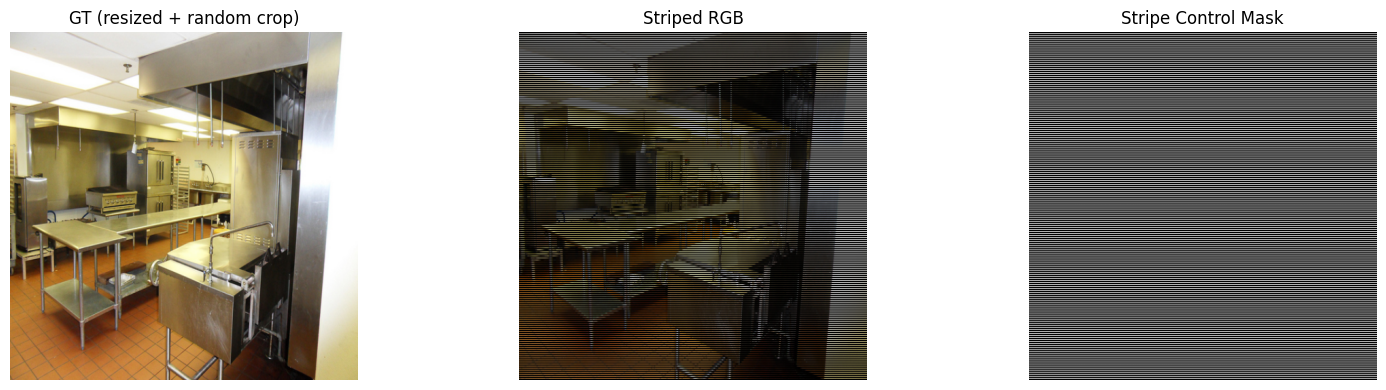

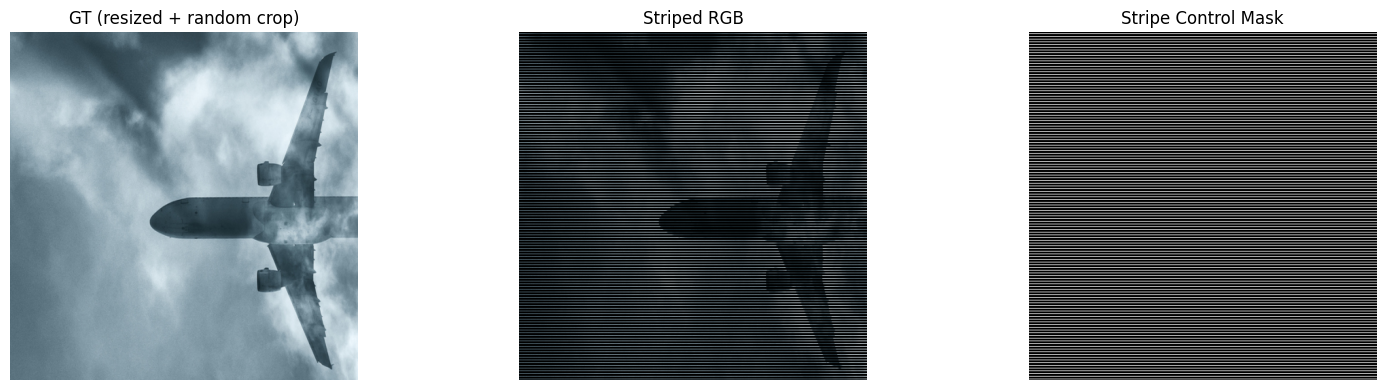

In [ ]:
batch = next(iter(train_dataloader))

def show_sample(batch, idx=0):
    gt = batch["H"][idx].permute(1, 2, 0).cpu().numpy()          # (H,W,3)
    striped = batch["control"][idx, :3].permute(1, 2, 0).cpu().numpy()
    mask = batch["control"][idx, 3].cpu().numpy()                # (H,W)

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))

    axs[0].imshow(gt)
    axs[0].set_title("GT (resized + random crop)")
    axs[0].axis("off")

    axs[1].imshow(striped)
    axs[1].set_title("Striped RGB")
    axs[1].axis("off")

    axs[2].imshow(mask, cmap="gray")
    axs[2].set_title("Stripe Control Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

show_sample(batch, 0)
show_sample(batch, 1)

## **Training**

In [ ]:
class StripeTrainingConfig:
    pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
    output_dir = "/content/drive/MyDrive/Experiments_Stripes1/controlnet_stripes_v1"

    # set to None if training from scratch instead of resuming
    resume_from = "/content/drive/MyDrive/Experiments_Stripes1/controlnet_stripes_v1/last_state"

    # Dataset
    image_root = "/content/drive/MyDrive/images"
    image_resolution = 512

    # Training
    learning_rate = 2e-5
    num_train_epochs = 100
    train_batch_size = 42
    gradient_accumulation_steps = 3

    # Scheduler
    lr_warmup_steps = 500

    # Logging / saving
    checkpointing_steps = 1000
    mixed_precision = "bf16"

In [ ]:
def train_stripe_controlnet(config: StripeTrainingConfig):
    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        mixed_precision=config.mixed_precision,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )

    # Models
    tokenizer = CLIPTokenizer.from_pretrained(
        config.pretrained_model_name_or_path, subfolder="tokenizer"
    )
    text_encoder = CLIPTextModel.from_pretrained(
        config.pretrained_model_name_or_path, subfolder="text_encoder"
    )
    vae = AutoencoderKL.from_pretrained(
        config.pretrained_model_name_or_path, subfolder="vae"
    )
    unet = UNet2DConditionModel.from_pretrained(
        config.pretrained_model_name_or_path, subfolder="unet"
    )
    noise_scheduler = DDPMScheduler.from_pretrained(
        config.pretrained_model_name_or_path, subfolder="scheduler"
    )

    # ControlNet
    if getattr(config, "resume_from", None) and os.path.isdir(config.resume_from):
        controlnet_path = os.path.join(config.resume_from, "controlnet")
        print(f"Resuming ControlNet from checkpoint: {controlnet_path}")

        # Start from UNet
        controlnet = ControlNetModel.from_unet(unet)

        # Adjust conv_in to 4 channels
        original_conv = controlnet.controlnet_cond_embedding.conv_in
        new_conv_in = torch.nn.Conv2d(
            4,  # 3 striped RGB + 1 stripe_control
            original_conv.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        controlnet.controlnet_cond_embedding.conv_in = new_conv_in

        # Load weights
        from safetensors.torch import load_file

        st_path_sft = os.path.join(controlnet_path, "diffusion_pytorch_model.safetensors")
        st_path_bin = os.path.join(controlnet_path, "diffusion_pytorch_model.bin")

        if os.path.exists(st_path_sft):
            print("Loading weights from .safetensors")
            state_dict = load_file(st_path_sft, device="cpu")
        elif os.path.exists(st_path_bin):
            print("Loading weights from .bin")
            state_dict = torch.load(st_path_bin, map_location="cpu")
        else:
            raise FileNotFoundError(f"No weights file found in {controlnet_path}")

        missing, unexpected = controlnet.load_state_dict(state_dict, strict=False)
        print("Loaded ControlNet state_dict.")
        if missing:
            print("Missing keys:", missing)
        if unexpected:
            print("Unexpected keys:", unexpected)

    else:
        print("Initializing NEW ControlNet with 4-channel conditioning...")
        controlnet = ControlNetModel.from_unet(unet)
        original_conv = controlnet.controlnet_cond_embedding.conv_in
        new_conv_in = torch.nn.Conv2d(
            4,
            original_conv.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        controlnet.controlnet_cond_embedding.conv_in = new_conv_in
        print("✅ ControlNet conv_in now expects 4 channels.")

    # Freeze base SD parts
    vae.requires_grad_(False)
    unet.requires_grad_(False)
    text_encoder.requires_grad_(False)
    controlnet.train()

    # Dataset & Dataloader
    print("Setting up Stripe dataset (online generation)...")
    train_dataset = StripeControlNetOnlineDataset(
        image_root=config.image_root,
        image_size=config.image_resolution,
        check_size=config.image_resolution,
        # ~25% visibility on average:
        skip_options=[3, 4, 5, 6],
        skip_probs=[0.15, 0.50, 0.25, 0.10],
    )
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config.train_batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )

    # Optimizer & Scheduler
    optimizer = torch.optim.AdamW(controlnet.parameters(), lr=config.learning_rate)

    max_train_steps = config.num_train_epochs * len(train_dataloader)
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=max_train_steps,
    )

    # Prepare with Accelerator
    controlnet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        controlnet, optimizer, train_dataloader, lr_scheduler
    )

    # Dtypes
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
    else:
        weight_dtype = torch.float32

    vae.to(accelerator.device, dtype=weight_dtype)
    text_encoder.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Precompute text embeddings
    print("Precomputing text embeddings...")
    with torch.no_grad():
        text_input = tokenizer(
            "a sharp, high-quality photograph",
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        prompt_embeds = text_encoder(text_input.input_ids.to(accelerator.device))[0]
    print("✅ Text embeddings ready.")

    # Training loop
    global_step = 0
    os.makedirs(config.output_dir, exist_ok=True)
    print("🚀 Starting training...")

    for epoch in range(config.num_train_epochs):
        controlnet.train()
        progress_bar = tqdm(
            train_dataloader,
            desc=f"Epoch {epoch+1}/{config.num_train_epochs}",
            disable=not accelerator.is_local_main_process,
        )

        for step, batch in enumerate(progress_bar):
            gt = batch["H"].to(accelerator.device)          # (B,3,H,W) in [0,1]
            control = batch["control"].to(accelerator.device)  # (B,4,H,W) in [0,1]

            # Scale images to [-1,1]
            gt = gt * 2.0 - 1.0
            control_rgb = control[:, :3, :, :] * 2.0 - 1.0
            control_extra = control[:, 3:, :, :]  # stripe_control stays [0,1]
            control = torch.cat([control_rgb, control_extra], dim=1)  # (B,4,H,W)

            # Encode GT to latents
            latents = vae.encode(gt.to(dtype=weight_dtype)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor  # (B,4,h,w)

            # Sample noise & timesteps
            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (latents.shape[0],),
                device=latents.device,
            ).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Text conditioning (same prompt repeated for batch)
            encoder_hidden_states = prompt_embeds.repeat(latents.shape[0], 1, 1)

            # ControlNet forward
            down_block_res_samples, mid_block_res_sample = controlnet(
                noisy_latents,
                timesteps,
                encoder_hidden_states,
                controlnet_cond=control.to(dtype=weight_dtype),
                return_dict=False,
            )

            # UNet forward with ControlNet residuals
            model_pred = unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states,
                down_block_additional_residuals=[
                    res.to(dtype=weight_dtype) for res in down_block_res_samples
                ],
                mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
            ).sample

            # Noise prediction loss
            loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

            accelerator.backward(loss)
            accelerator.clip_grad_norm_(controlnet.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1
            progress_bar.set_postfix(
                loss=loss.detach().item(),
                lr=lr_scheduler.get_last_lr()[0],
            )
            accelerator.log({"loss": loss.detach().item()}, step=global_step)

            # Checkpoint
            if accelerator.is_main_process and global_step % config.checkpointing_steps == 0:
                save_path = os.path.join(config.output_dir, "last_state")
                accelerator.save_state(save_path)
                unwrapped = accelerator.unwrap_model(controlnet)
                unwrapped.save_pretrained(os.path.join(save_path, "controlnet"))
                print(f"💾 Saved checkpoint at step {global_step}")

        # Epoch checkpoint
        if accelerator.is_main_process:
            save_path = os.path.join(
                config.output_dir, f"checkpoint-epoch-{epoch+1}"
            )
            unwrapped = accelerator.unwrap_model(controlnet)
            unwrapped.save_pretrained(save_path)
            print(f"✅ Epoch {epoch+1} checkpoint saved to {save_path}")

    # Final save
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unwrapped = accelerator.unwrap_model(controlnet)
        unwrapped.save_pretrained(os.path.join(config.output_dir, "final_model"))
        print(f"🎉 Training finished. Final model saved to {config.output_dir}")
    accelerator.end_training()

In [ ]:
if __name__ == "__main__":
    cfg = StripeTrainingConfig()
    num_gpus = 1
    notebook_launcher(train_stripe_controlnet, args=(cfg,), num_processes=num_gpus)

Launching training on one GPU.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

Resuming ControlNet from checkpoint: /content/drive/MyDrive/Experiments_Stripes1/controlnet_stripes_v1/last_state/controlnet
Loading weights from .safetensors
Loaded ControlNet state_dict.
Setting up Stripe dataset (online generation)...
Found 43525 images in /content/drive/MyDrive/images
Precomputing text embeddings...
✅ Text embeddings ready.
🚀 Starting training...


Epoch 1/100:   0%|          | 0/1037 [00:00<?, ?it/s]

KeyboardInterrupt: 